# imports

In [50]:
import matplotlib.pyplot as plt
import math
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.metrics import (adjusted_mutual_info_score as AMI,
                             adjusted_rand_score as ARI,
                             homogeneity_score, completeness_score,
                             v_measure_score, normalized_mutual_info_score as NMI,
                             silhouette_score, pairwise_distances)
from sklearn.cluster import (KMeans, MiniBatchKMeans, SpectralClustering,
                             AgglomerativeClustering, DBSCAN, OPTICS, cluster_optics_dbscan)
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.optimize import linear_sum_assignment  # Hungarian
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage

warnings.filterwarnings("ignore", message="The number of unique classes.*") 
warnings.filterwarnings("ignore", message="Graph is not fully connected.*") 


# Classification

## data preparing


In [51]:
COLS = ["obj_ID",	"alpha",	"delta",	"u",	"g",	"r",	"i",	"z",	"run_ID",	"rerun_ID",	"cam_col",	"field_ID",	"spec_obj_ID",	"class",	"redshift",	"plate",	"MJD",	"fiber_ID"]
TARGET_COL = "class"     # 'GALAXY'/'STAR'/'QSO'
USE_PCA = True
PCA_VAR_KEEP = 0.95
SPECTRAL_MAX_N = 15000    # сэмплим для Spectral, чтобы не утонуть в памяти
RANDOM_STATE = 0

ID_LIKE = ("obj_ID","_ID","run_ID","rerun_ID","field_ID",
                "spec_obj_ID","plate","MJD","fiber_ID")



df = pd.read_csv("data/star_classification.csv")
df = df.replace({".": np.nan})
df.head(10)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
5,1.237680e+18,340.995121,20.589476,23.48827,23.33776,21.32195,20.25615,19.54544,8102,301,3,110,5.658977e+18,QSO,1.424659,5026,55855,741
6,1.237679e+18,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,7773,301,2,462,1.246262e+19,QSO,0.586455,11069,58456,113
7,1.237679e+18,5.433176,12.065186,22.24979,22.02172,20.34126,19.48794,18.84999,7773,301,2,346,6.961443e+18,GALAXY,0.477009,6183,56210,15
8,1.237661e+18,200.290475,47.199402,24.40286,22.35669,20.61032,19.46490,18.95852,3716,301,5,108,7.459285e+18,GALAXY,0.660012,6625,56386,719
9,1.237671e+18,39.149691,28.102842,21.74669,20.03493,19.17553,18.81823,18.65422,5934,301,4,122,2.751763e+18,STAR,-0.000008,2444,54082,232


In [52]:

# y из столбца TARGET_COL
if TARGET_COL not in df.columns:
    raise ValueError(f"Нет столбца '{TARGET_COL}' в датасете")
y_raw = df[TARGET_COL].astype(str)

# Только числовые фичи
num = df.select_dtypes(include=[np.number]).copy()

# Выбросим ID-поля
for col in list(num.columns):
    if any(pat in col for pat in ID_LIKE):
        num.drop(columns=[col], inplace=True)

# Уберём строки с NaN в фичах и синхронизируем y
mask = ~num.isna().any(axis=1)
Xdf = num.loc[mask].copy()
y_raw = y_raw.loc[mask].copy()

# Кодировка классов в 0..K-1
classes, y = np.unique(y_raw.values, return_inverse=True)
classes = [str(c) for c in classes]

Xdf.shape, len(y), classes[:3]
Xdf

,alpha,delta,u,g,r,i,z,cam_col,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,2,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,5,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,2,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,3,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,3,0.116123
...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,2,0.000000
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,1,0.404895
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,4,0.143366
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,4,0.455040


# Clusterization

### === Scale & PCA ===

In [12]:
def cluster_soft_scores(y_true, labels, n_classes):
    labels = np.asarray(labels)
    uniq = np.unique(labels)
    noise_mask = (labels == -1)
    clust_ids = np.array([u for u in uniq if u != -1], dtype=int)
    clust_map = {c:i for i,c in enumerate(clust_ids)}
    C = np.zeros((len(clust_ids), n_classes), dtype=int)
    for lab, yt in zip(labels, y_true):
        if lab != -1:
            C[clust_map[lab], yt] += 1
    if C.size:
        r, c = linear_sum_assignment(-C)  # max assignment
        row2cls = dict(zip(r, c))
    else:
        row2cls = {}
    y_pred_hard = np.full_like(y_true, -1)
    for i, lab in enumerate(labels):
        if lab != -1:
            y_pred_hard[i] = row2cls.get(clust_map[lab], 0)
    proba = np.zeros((len(labels), n_classes), float)
    row_sums = C.sum(axis=1, keepdims=True); row_sums[row_sums==0] = 1
    P = C / row_sums
    for i, lab in enumerate(labels):
        proba[i, :] = (1.0/n_classes) if lab == -1 else P[clust_map[lab]]
    return C, y_pred_hard, proba

def report_and_plots(model_name, y_true, labels, classes, figsize=(12,5)):
    n_classes = len(classes)
    C, y_pred_hard, proba = cluster_soft_scores(y_true, labels, n_classes)
    f1_macro = (f1_score(y_true[y_pred_hard!=-1], y_pred_hard[y_pred_hard!=-1], average="macro")
                if np.any(y_pred_hard!=-1) else np.nan)
    try:
        roc_macro = roc_auc_score(y_true, proba, multi_class="ovr", average="macro")
    except Exception:
        roc_macro = np.nan
    try:
        pr_macro = np.mean([average_precision_score((y_true==k).astype(int), proba[:,k])
                            for k in range(n_classes)])
    except Exception:
        pr_macro = np.nan
    print(f"[{model_name}]  F1-macro={f1_macro:.4f} | ROC-AUC(macro, OvR)={roc_macro:.4f} | PR-AUC(macro)={pr_macro:.4f}")

    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1,2,1)
    for k, cls in enumerate(classes):
        yb = (y_true==k).astype(int)
        P, R, _ = precision_recall_curve(yb, proba[:,k])
        ap = average_precision_score(yb, proba[:,k])
        ax1.plot(R, P, label=f"{cls} (AP={ap:.3f})")
    ax1.set_xlabel("Recall"); ax1.set_ylabel("Precision"); ax1.set_title(f"PR (OvR): {model_name}")
    ax1.legend(fontsize=8); ax1.grid(True, alpha=0.3)

    ax2 = fig.add_subplot(1,2,2)
    for k, cls in enumerate(classes):
        yb = (y_true==k).astype(int)
        F, T, _ = roc_curve(yb, proba[:,k])
        ax2.plot(F, T, label=f"{cls} (AUC={auc(F,T):.3f})")
    ax2.plot([0,1],[0,1],'--',lw=1)
    ax2.set_xlabel("FPR"); ax2.set_ylabel("TPR"); ax2.set_title(f"ROC (OvR): {model_name}")
    ax2.legend(fontsize=8); ax2.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()
    return dict(F1_macro=f1_macro, ROC_AUC_macro=roc_macro, PR_AUC_macro=pr_macro, C=C)

In [13]:

scaler = StandardScaler()
Xs = scaler.fit_transform(Xdf.values)

pca_info = {"pca_used": False, "pca_n": Xs.shape[1], "explained": 1.0}
if USE_PCA and Xs.shape[1] > 20:
    pca = PCA(n_components=PCA_VAR_KEEP, svd_solver="full", random_state=RANDOM_STATE)
    Xs = pca.fit_transform(Xs)
    pca_info.update({
        "pca_used": True,
        "pca_n": Xs.shape[1],
        "explained": float(np.sum(pca.explained_variance_ratio_))
    })

print(f"[INFO] samples={len(Xs)}, dims={Xdf.shape[1]} -> after_pca={pca_info['pca_n']} "
      f"(used={pca_info['pca_used']}, explained={pca_info['explained']:.3f})")

[INFO] samples=100000, dims=9 -> after_pca=9 (used=False, explained=1.000)


### === Metrics helpers ===

In [14]:

def eval_labels(name: str, y_true: np.ndarray, labels: np.ndarray, X: np.ndarray) -> dict:
    k_pred = len(set(labels)) - (1 if -1 in labels else 0)
    noise = int(np.sum(labels == -1))
    row = dict(
        name=name, k_pred=int(k_pred), noise=int(noise),
        AMI=AMI(y_true, labels), ARI=ARI(y_true, labels),
        hom=homogeneity_score(y_true, labels),
        comp=completeness_score(y_true, labels),
        v=v_measure_score(y_true, labels),
        NMI=NMI(y_true, labels, average_method="arithmetic"),
        sil=np.nan
    )
    uniq = [c for c in np.unique(labels) if c != -1]
    if len(uniq) >= 2 and len(uniq) < len(labels):
        try:
            row["sil"] = float(silhouette_score(X, labels, metric="euclidean"))
        except Exception:
            pass
    return row

def median_heuristic_gamma(X: np.ndarray) -> float:
    D = pairwise_distances(X)
    med = np.median(D)
    return 1.0 / (med**2 + 1e-12)

### === DENDRO HELPERS: авто-разрез ("большой разрыв") + рисовалка ===


In [15]:
def largest_gap_cut(Z, guard_low=0.10, guard_high=0.02, relative=True, clip_k=(2, 2000)):
    """
    Ищем разрез по макс. скачку высот слияний h = Z[:,2].
    Возвращает (k_pred, cut_height). guard_* — защита от шумных краёв.
    """
    h = Z[:, 2]
    n = len(h) + 1
    lo = max(1, int(len(h) * guard_low))
    hi = max(lo + 1, int(len(h) * (1 - guard_high)))
    dh = np.diff(h[lo:hi])
    denom = np.maximum(h[lo+1:hi], 1e-12)
    score = dh / denom if relative else dh
    if score.size == 0:
        return max(clip_k[0], n - 1), float(h[-1])
    j = int(np.argmax(score)); i = lo + j
    k_pred = int(np.clip(n - (i + 1), clip_k[0], min(clip_k[1], n)))
    cut_h = 0.5 * (h[i] + (h[i+1] if i+1 < len(h) else h[i]))
    return k_pred, float(cut_h)

def plot_dendro_with_cut(Z, cut_h, title="", p=6, figsize=(12, 5)):
    plt.figure(figsize=figsize)
    dendrogram(Z, truncate_mode="level", p=p, color_threshold=cut_h)  # порог цветом
    plt.axhline(cut_h, ls="--", lw=1)
    plt.title(title); plt.xlabel("objects"); plt.ylabel("distance")
    plt.tight_layout(); plt.show()

### === Agglomerative grid ===

[Agg] best dendrogram on sample: average/euclidean, k≈400, AMI=0.152


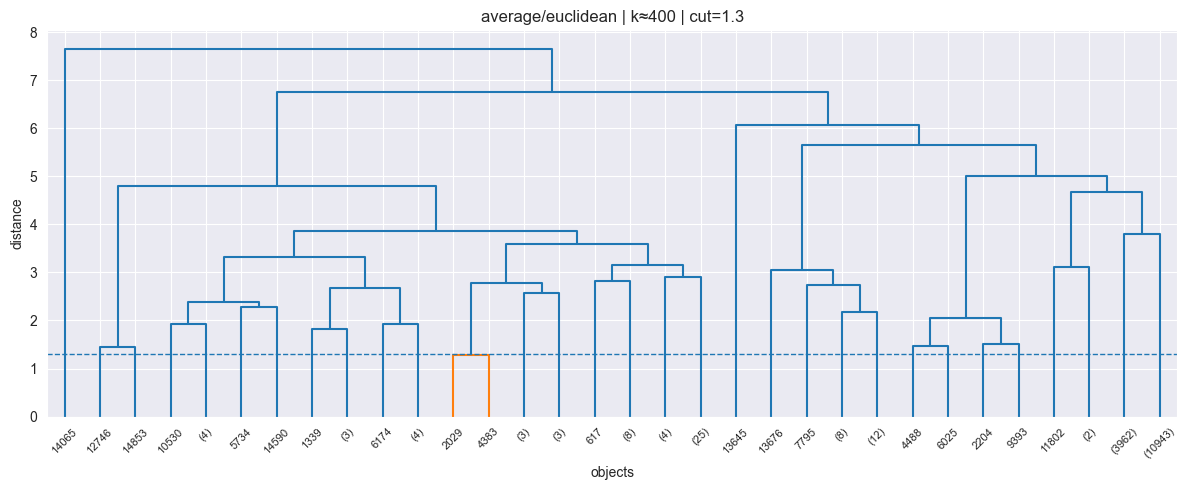

[Dendro[average,euclidean] k≈400]  F1-macro=0.2908 | ROC-AUC(macro, OvR)=0.8960 | PR-AUC(macro)=0.8212


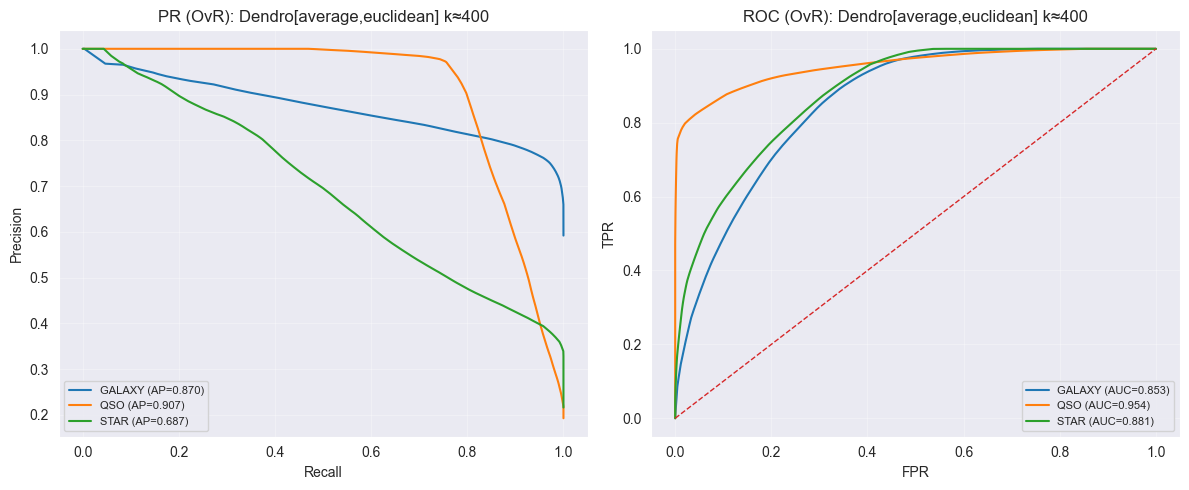

[Agg[average,euclidean]-full(k=3)]  F1-macro=0.2486 | ROC-AUC(macro, OvR)=0.5000 | PR-AUC(macro)=0.3334


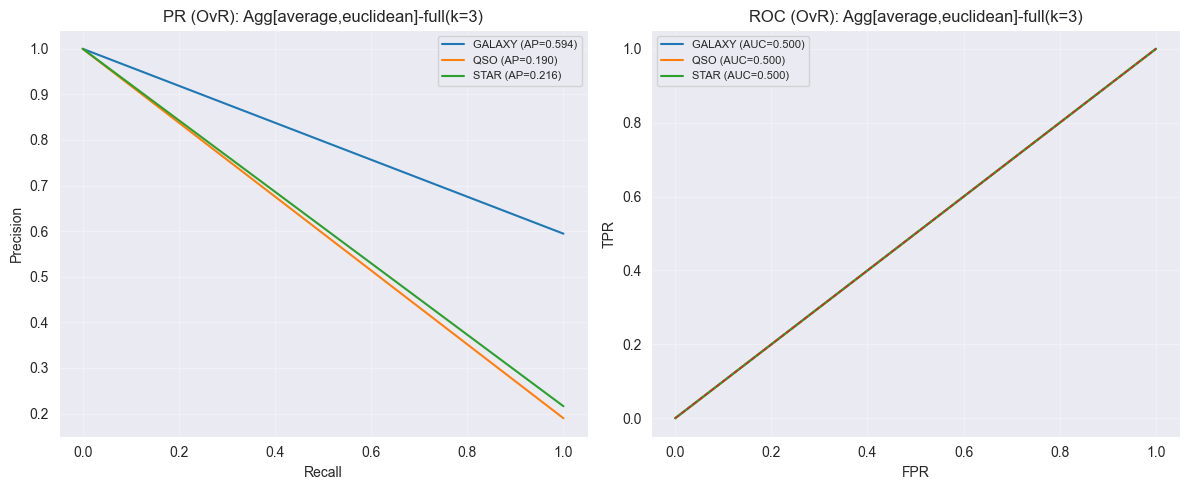

In [25]:

rows = []
k_true = 3

rng = np.random.RandomState(RANDOM_STATE)
n_d = min(15000, len(Xs))          # 15000..20000 — оптимально
idx = rng.choice(len(Xs), size=n_d, replace=False)
Xa, ya = Xs[idx], y[idx]

# кандидаты; напоминание: ward корректен только с 'euclidean'
dendro_cands = [
    ("single","euclidean"),
    ("complete","euclidean"),
    ("average","euclidean"),
    # ("weighted","euclidean"),
    # ("complete","cosine"),
    # ("average","cityblock"),
    # ("ward","euclidean"),
]

results = []
for link, metric in dendro_cands:
    if link == "ward" and metric != "euclidean":
        continue
    Z = linkage(Xa, method=link, metric=metric)
    k_pred, cut_h = largest_gap_cut(Z, relative=True)
    labels_tree = fcluster(Z, t=cut_h, criterion="distance")  # плоская разметка по порогу
    ami = AMI(ya, labels_tree)
    results.append((ami, link, metric, k_pred, cut_h, Z, labels_tree))

if not results:
    print("[Agg] no dendrogram candidate produced")
else:
    # лучший по AMI на сэмпле
    results.sort(key=lambda r: r[0], reverse=True)
    best_ami, best_link, best_metric, best_k, best_cut, Zbest, labels_best = results[0]
    print(f"[Agg] best dendrogram on sample: {best_link}/{best_metric}, k≈{best_k}, AMI={best_ami:.3f}")
    plot_dendro_with_cut(Zbest, best_cut, title=f"{best_link}/{best_metric} | k≈{best_k} | cut={best_cut:.3g}")

    # отчёт по дендро-срезу на сэмпле
    rows.append(eval_labels(f"Dendro[{best_link},{best_metric}] k≈{best_k}", ya, labels_best, Xa))
    report_and_plots(f"Dendro[{best_link},{best_metric}] k≈{best_k}", ya, labels_best, classes)

    # связность для полного набора
    n_ngb = max(10, int(min(30, math.sqrt(len(Xs)))))
    try:
        connectivity = kneighbors_graph(Xs, n_neighbors=n_ngb, include_self=False)
    except Exception:
        connectivity = None

    # финальный Agglomerative на всём X: фиксируем число кластеров для сопоставимости (k_true)
    n_clusters_full = k_true
    agg = AgglomerativeClustering(n_clusters=n_clusters_full, linkage=best_link, metric=best_metric,
                                  connectivity=connectivity if (best_link!="ward" or best_metric=="euclidean") else None)

    lab_full = agg.fit_predict(Xs)
    name = f"Agg[{best_link},{best_metric}]-full(k={n_clusters_full})"
    rows.append(eval_labels(name, y, lab_full, Xs))
    report_and_plots(name, y, lab_full, classes)

### === KMeans / MiniBatchKMeans ===

[KMeans] best k by silhouette on sample: 2
[KMeans(k=2)]  F1-macro=0.2486 | ROC-AUC(macro, OvR)=0.5000 | PR-AUC(macro)=0.3333


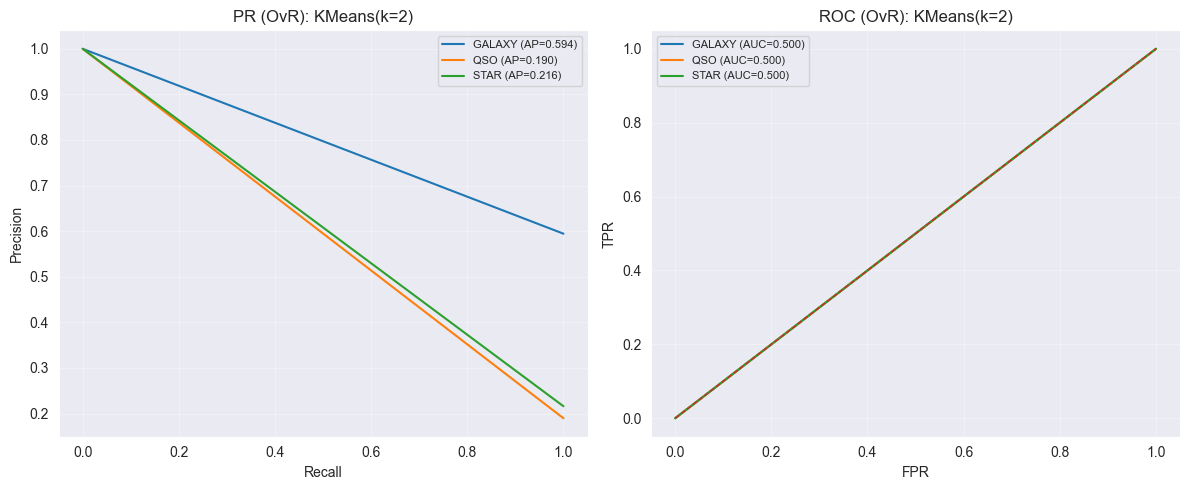

[MBKMeans(k=2)]  F1-macro=0.3354 | ROC-AUC(macro, OvR)=0.6287 | PR-AUC(macro)=0.3978


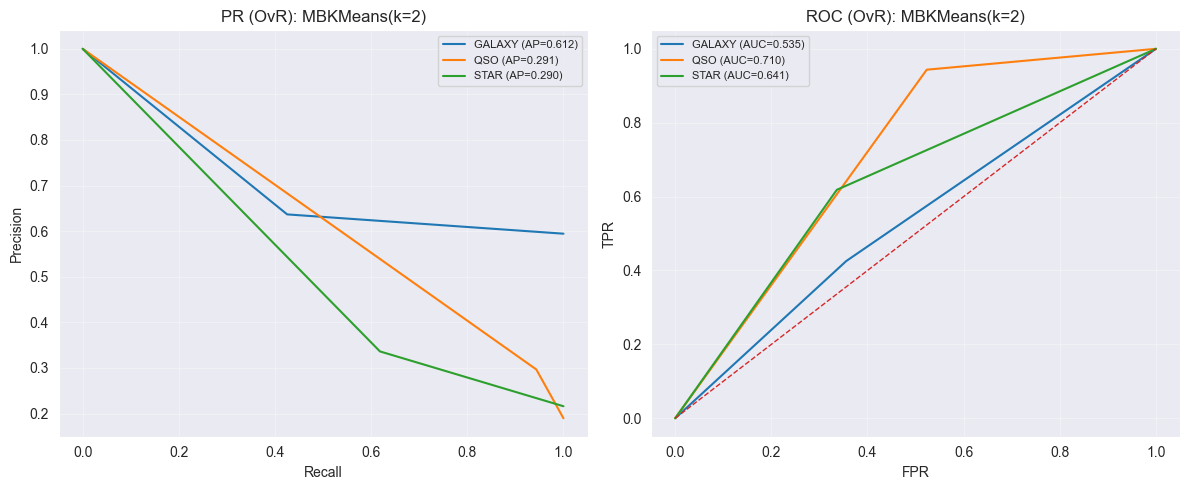

In [17]:
rng = np.random.RandomState(RANDOM_STATE)
sample_n = min(20000, len(Xs))
idx = rng.choice(len(Xs), size=sample_n, replace=False)
X_sm, y_sm = Xs[idx], y[idx]

k_grid = range(max(2, k_true-2), k_true+3)  # узкая сетка вокруг числа классов
best = None
for k in k_grid:
    km = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE, algorithm="elkan")
    lab = km.fit_predict(X_sm)
    if len(np.unique(lab)) < 2:
        continue
    sil = silhouette_score(X_sm, lab)
    best = (sil, k) if best is None or sil > best[0] else best

k_best = best[1] if best else k_true
print(f"[KMeans] best k by silhouette on sample: {k_best}")

# Запуск на всём: KMeans и MiniBatchKMeans
res_kmeans = {}
for name, model in [
    (f"KMeans(k={k_best})", KMeans(n_clusters=k_best, n_init=20, random_state=RANDOM_STATE, algorithm="elkan")),
    (f"MBKMeans(k={k_best})", MiniBatchKMeans(n_clusters=k_best, n_init=20, random_state=RANDOM_STATE, batch_size=4096)),
]:
    labels = model.fit_predict(Xs)
    rows.append(eval_labels(name, y, labels, Xs))
    res_kmeans[name] = report_and_plots(name, y, labels, classes)


### === SpectralClustering (на сэмпле) ===


[Spectral(RBF,g=0.0976,discretize)]  F1-macro=0.4039 | ROC-AUC(macro, OvR)=0.6326 | PR-AUC(macro)=0.4024


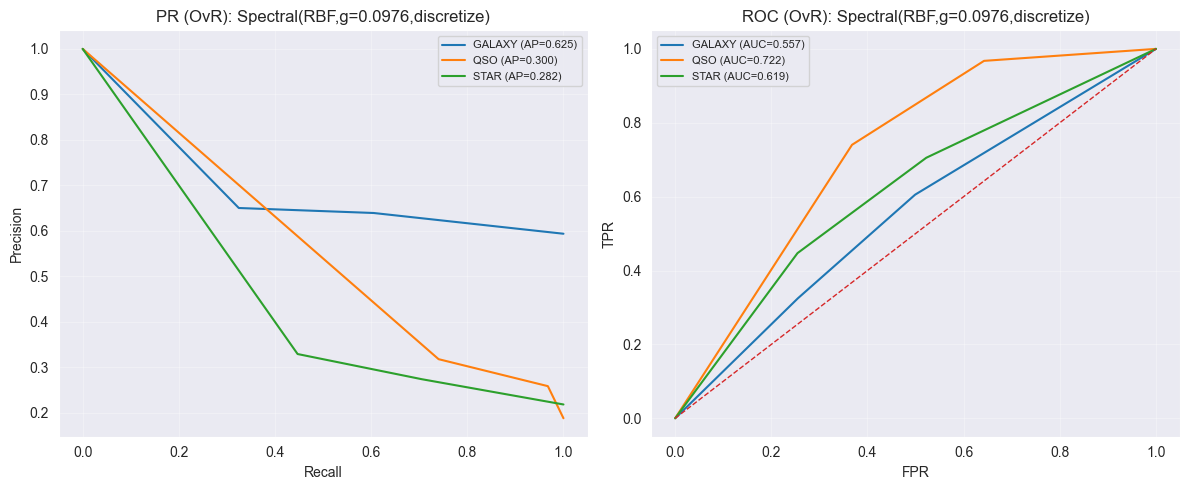

{'F1_macro': 0.40388525413345344,
 'ROC_AUC_macro': 0.632616680721817,
 'PR_AUC_macro': np.float64(0.40241906536527877),
 'C': array([[5783,  183, 2928],
        [4997, 1282, 1691],
        [7029, 4176, 1931]])}

In [19]:
if len(Xs) > SPECTRAL_MAX_N:
    rng = np.random.RandomState(RANDOM_STATE)
    idx = rng.choice(len(Xs), size=30000, replace=False)
    X_spec, y_spec = Xs[idx], y[idx]
else:
    X_spec, y_spec = Xs, y

gamma = median_heuristic_gamma(X_spec)

for assign in ("kmeans", "discretize"):
    try:
        spec = SpectralClustering(n_clusters=k_true, affinity="rbf",
                                  gamma=gamma, assign_labels=assign,
                                  random_state=RANDOM_STATE, n_init=10)
        labels = spec.fit_predict(X_spec)
        rows.append(eval_labels(f"Spectral(RBF,g={gamma:.3g},{assign})", y_spec, labels, X_spec))
    except Exception as e:
        rows.append(dict(name=f"Spectral({assign})", error=str(e)))
        
len(rows)
rows.append(eval_labels(f"Spectral(RBF,g={gamma:.3g},{assign})", y_spec, labels, X_spec))
report_and_plots(f"Spectral(RBF,g={gamma:.3g},{assign})", y_spec, labels, classes)

[DBSCAN(ms=5, eps=0.761)]  F1-macro=0.2497 | ROC-AUC(macro, OvR)=0.5054 | PR-AUC(macro)=0.3383


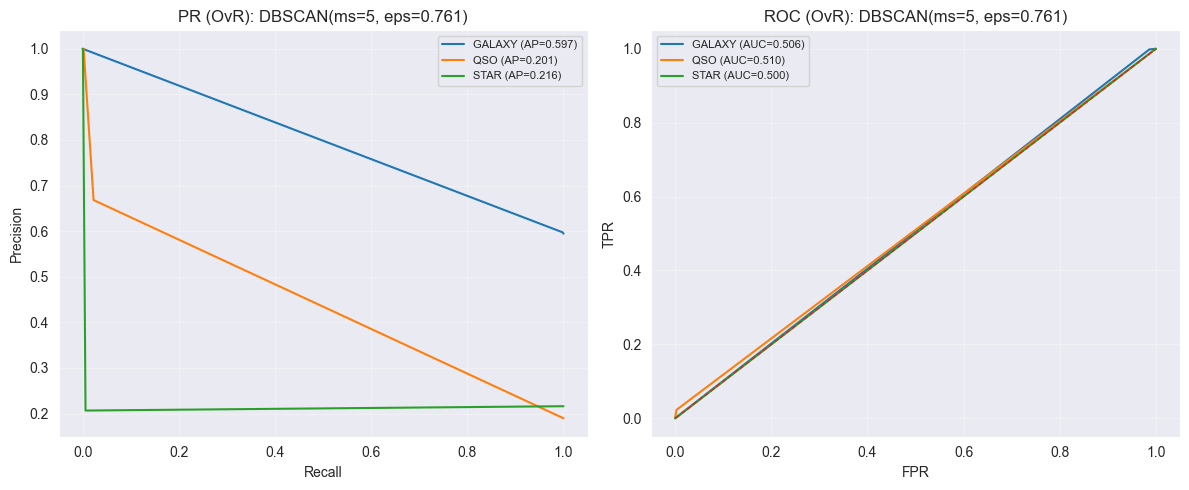

In [20]:
# === DBSCAN grid ===
ms_list = [5, 10, 20, 50, 500]
def knee_eps(X, min_samples=10, sample=20000, q=0.98):
    rng = np.random.RandomState(RANDOM_STATE)
    idx = rng.choice(len(X), size=min(sample, len(X)), replace=False)
    Xk = X[idx]
    nn = NearestNeighbors(n_neighbors=min_samples).fit(Xk)
    dist, _ = nn.kneighbors(Xk)
    kth = np.sort(dist[:, -1])
    # простая эвристика "сгиб": высокий квантиль (q ~ 0.98) как запасной вариант
    # (knee-детектор можно подключить позже)
    return float(np.quantile(kth, q))

db_best = None
for ms in ms_list:
    eps = knee_eps(Xs, min_samples=ms, sample=40000, q=0.98)
    model = DBSCAN(eps=eps, min_samples=ms)
    lab = model.fit_predict(Xs)
    score = AMI(y, lab)
    db_best = (score, ms, eps, lab) if db_best is None or score > db_best[0] else db_best

if db_best:
    score, ms, eps, lab = db_best
    name = f"DBSCAN(ms={ms}, eps={eps:.3f})"
    rows.append(eval_labels(name, y, lab, Xs))
    report_and_plots(name, y, lab, classes)
else:
    print("[DBSCAN] failed to find a workable config")


[OPTICS] best on sample: min_samples=5, xi=0.03
[OPTICS-xi(ms=5, xi=0.03)]  F1-macro=0.2526 | ROC-AUC(macro, OvR)=0.7730 | PR-AUC(macro)=0.6078


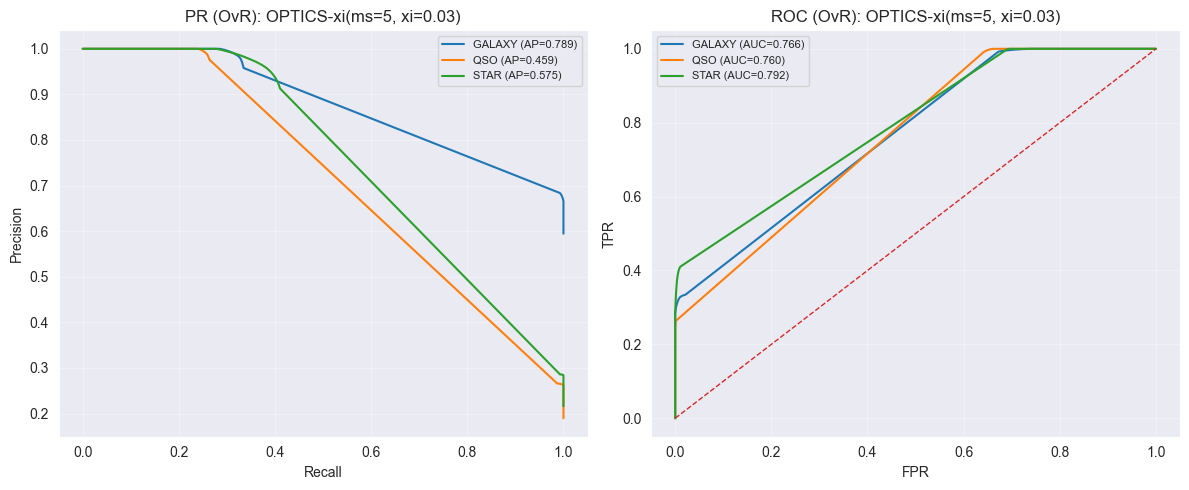

12

In [21]:
# === OPTICS ===
rng = np.random.RandomState(RANDOM_STATE)
idx = rng.choice(len(Xs), size=min(20000, len(Xs)), replace=False)
Xo, yo = Xs[idx], y[idx]

best = None
for ms in ms_list:
    for xi in (0.03, 0.05, 0.1):
        try:
            lab = OPTICS(min_samples=ms, xi=xi, cluster_method="xi", max_eps=np.inf).fit_predict(Xo)
            sc = AMI(yo, lab)
            best = (sc, ms, xi) if best is None or sc > best[0] else best
        except Exception:
            pass

if best:
    sc, ms, xi = best
    print(f"[OPTICS] best on sample: min_samples={ms}, xi={xi}")
    lab_full = OPTICS(min_samples=ms, xi=xi, cluster_method="xi", max_eps=np.inf).fit_predict(Xs)
    name = f"OPTICS-xi(ms={ms}, xi={xi})"
    rows.append(eval_labels(name, y, lab_full, Xs))
    report_and_plots(name, y, lab_full, classes)
else:
    print("[OPTICS] no config worked")
        
len(rows)

In [22]:
# === Results table ===
res = pd.DataFrame(rows)

# округление метрик
for c in ("AMI","ARI","hom","comp","v","NMI","sil"):
    if c in res:
        res[c] = pd.to_numeric(res[c], errors="coerce").round(4)

# сортировка
if {"AMI","ARI"}.issubset(res.columns):
    res = res.sort_values(["AMI","ARI","v"], ascending=False,
                          na_position="last").reset_index(drop=True)

display(res.head(20))
print(f"Всего конфигураций: {len(res)}")

# Сохранить при необходимости
# Path("cluster_bench_results.csv").write_text(res.to_csv(index=False), encoding="utf-8")
# print("[OK] Сохранено: cluster_bench_results.csv")

if len(res) and "name" in res.columns:
    print("[BEST]", res.iloc[0]["name"])

,name,k_pred,noise,AMI,ARI,hom,comp,v,NMI,sil
0,"Dendro[average,cityblock] k≈325",325,0,0.1702,0.0174,0.5275,0.1063,0.1769,0.1769,0.1248
1,"OPTICS-xi(ms=5, xi=0.03)",4198,65298,0.1156,0.0041,0.3159,0.0859,0.1350,0.1350,-0.4257
2,MBKMeans(k=2),2,0,0.1003,0.0404,0.0854,0.1215,0.1003,0.1003,0.2463
3,"Spectral(RBF,g=0.0971,discretize)",3,0,0.0764,0.0278,0.0813,0.0726,0.0767,0.0767,0.2207
4,"Spectral(RBF,g=0.0971,discretize)",3,0,0.0764,0.0278,0.0813,0.0726,0.0767,0.0767,0.2207
5,"Spectral(RBF,g=0.0971,kmeans)",3,0,0.0713,0.0201,0.0749,0.0685,0.0716,0.0716,0.2247
6,"Spectral(RBF,g=0.0976,discretize)",3,0,0.0672,0.0224,0.0714,0.0635,0.0672,0.0672,0.2243
7,"Spectral(RBF,g=0.0976,discretize)",3,0,0.0672,0.0224,0.0714,0.0635,0.0672,0.0672,0.2243
8,"Spectral(RBF,g=0.0976,kmeans)",3,0,0.0661,0.0190,0.0694,0.0632,0.0661,0.0661,0.2248
9,"DBSCAN(ms=5, eps=0.761)",9,605,0.0083,0.0084,0.0044,0.1006,0.0085,0.0085,0.1288


Всего конфигураций: 12
[BEST] Dendro[average,cityblock] k≈325


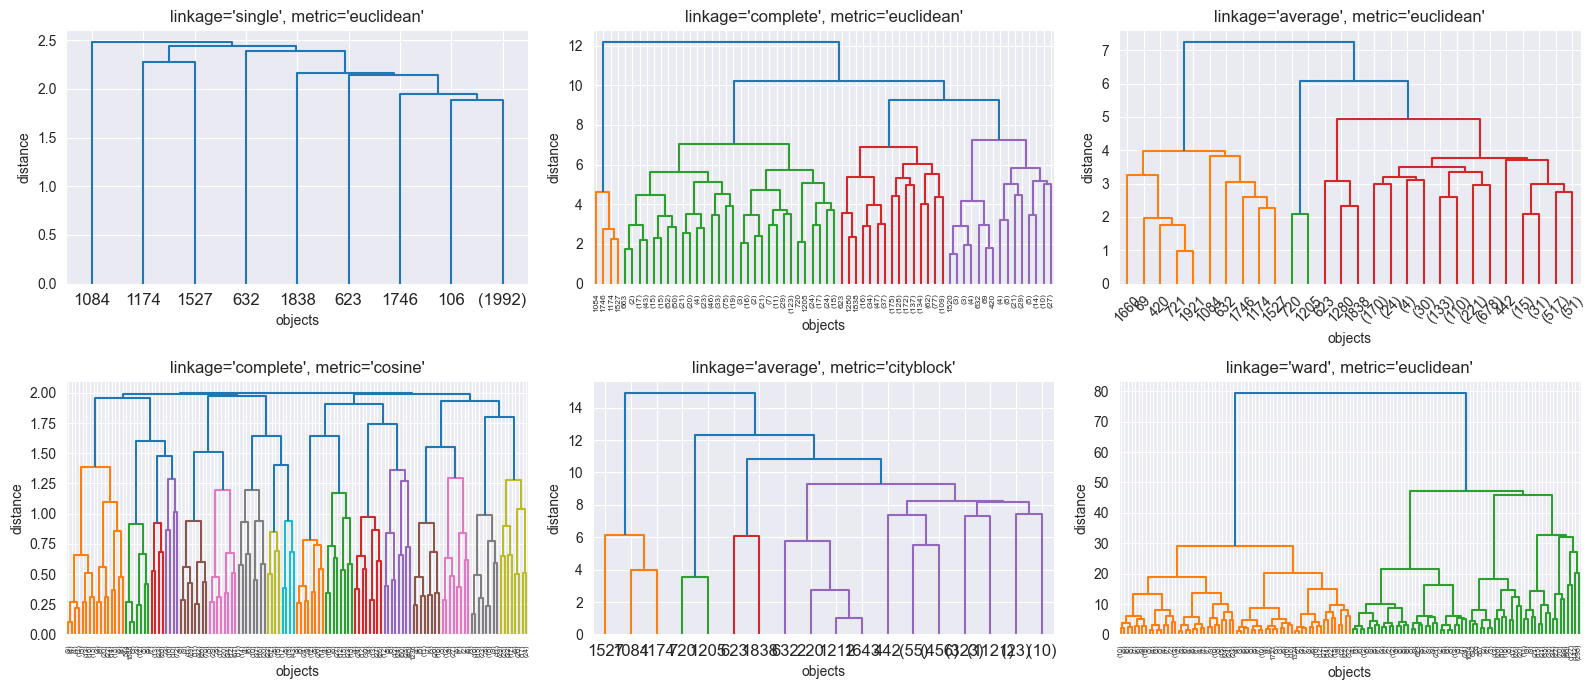

In [24]:
# === Dendrogram (optional, on sample) ===
# ВНИМАНИЕ: полные dendrogram на больших N — бесполезный обогреватель комнаты.
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

sample_n = min(2000, len(Xs))
rng = np.random
idx = rng.choice(len(Xs), size=sample_n, replace=False)
Xd = Xs[idx]; yd = y[idx]

dendro_select = [
    ("single",   "euclidean"),
    ("complete", "euclidean"),
    ("average",  "euclidean"),
    ("complete", "cosine"),
    ("average",  "cityblock"),
    ("ward",     "euclidean"),
]

fig_rows, fig_cols = 2, math.ceil(len(dendro_select)/2)
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(16, 7))
axes = axes.ravel()

for i, (method, metric) in enumerate(dendro_select):
    Z = linkage(Xd, method=method, metric=metric)
    dendrogram(Z, ax=axes[i], truncate_mode="level", p=6)
    axes[i].set_title(f"linkage='{method}', metric='{metric}'")
    axes[i].set_ylabel("distance"); axes[i].set_xlabel("objects")

for j in range(len(dendro_select), len(axes)):
    axes[j].axis("off")
plt.tight_layout(); plt.show()

['class_GALAXY', 'class_QSO', 'class_STAR']


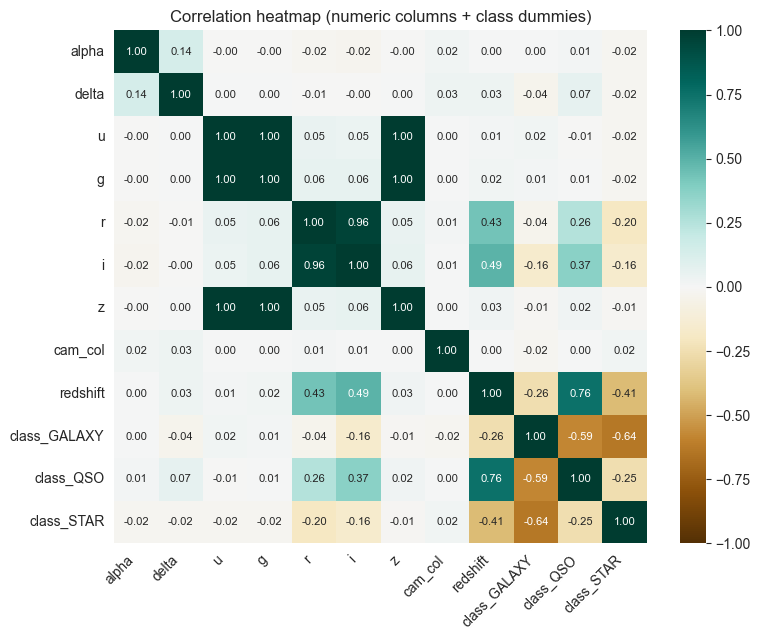

,alpha,delta,u,g,r,i,z,cam_col,redshift,class_GALAXY,class_QSO,class_STAR
alpha,1.000000,0.138691,-0.001532,-0.002423,-0.022083,-0.023580,-0.002918,0.019582,0.001667,0.004085,0.014261,-0.018461
delta,0.138691,1.000000,0.002074,0.003523,-0.006835,-0.004480,0.003630,0.032565,0.031638,-0.038297,0.065825,-0.017011
u,-0.001532,0.002074,1.000000,0.999311,0.054149,0.045730,0.998093,0.003548,0.014309,0.023129,-0.006590,-0.021321
g,-0.002423,0.003523,0.999311,1.000000,0.062387,0.056271,0.999161,0.003508,0.022954,0.014289,0.006015,-0.022780
r,-0.022083,-0.006835,0.054149,0.062387,1.000000,0.962868,0.053677,0.008480,0.433241,-0.037997,0.255142,-0.197722
i,-0.023580,-0.004480,0.045730,0.056271,0.962868,1.000000,0.055994,0.007615,0.492383,-0.160379,0.370459,-0.161545
z,-0.002918,0.003630,0.998093,0.999161,0.053677,0.055994,1.000000,0.003365,0.030380,-0.008382,0.024361,-0.013206
cam_col,0.019582,0.032565,0.003548,0.003508,0.008480,0.007615,0.003365,1.000000,0.000097,-0.020569,0.003317,0.021384
redshift,0.001667,0.031638,0.014309,0.022954,0.433241,0.492383,0.030380,0.000097,1.000000,-0.256925,0.756649,-0.414245
class_GALAXY,0.004085,-0.038297,0.023129,0.014289,-0.037997,-0.160379,-0.008382,-0.020569,-0.256925,1.000000,-0.585624,-0.635371


In [45]:
# [HEATMAP WITH CLASS DUMMIES — SHORT]

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

FEATS = Xdf.copy()

# 1) Получаем числовой вектор y (если есть) или маппим из df["class"]
if "y" in globals() and len(FEATS) == len(y):
    y_vec = np.asarray(y, dtype=int)
    # список имён классов
    CLS = list(classes) if "classes" in globals() else sorted(np.unique(y_vec).tolist())
else:
    # берём классы из 'classes' если заданы, иначе из df
    if "classes" in globals():
        CLS = list(classes)
        CLS_U = [c.upper() for c in CLS]
    else:
        CLS = sorted(FEATS["class"].astype(str).str.strip().str.upper().unique().tolist())
        CLS_U = CLS
    name2id = {name:i for i, name in enumerate(CLS_U)}
    y_vec = FEATS["class"].astype(str).str.strip().str.upper().map(name2id).astype(int).to_numpy()

# 2) Удаляем исходный столбец классов и добавляем 3 индикатора (OvR)
FEATS = FEATS.drop(columns=["class"], errors="ignore")
for k, c in enumerate(CLS):
    FEATS[f"class_{c}"] = (y_vec == k).astype(int)

# 3) Считаем корреляции Pearson по всем ЧИСЛОВЫМ столбцам (ID останутся, если числовые)
NUM = FEATS.select_dtypes(include=[np.number])
corr = NUM.corr(method="pearson")

# (опционально убедимся, что классы на месте)
print([c for c in corr.columns if c.startswith("class_")])

# 3) теплокарта без масок, с числами
n = len(cols)
plt.figure(figsize=(max(8, 0.5*n + 3), max(6, 0.5*n + 2)))
ax = sns.heatmap(corr, vmin=-1, vmax=1, cmap="BrBG",
                 annot=True, fmt=".2f", annot_kws={"size":8}, linewidths=0)
ax.set_title("Correlation heatmap (numeric columns + class dummies)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout(); plt.show()
corr

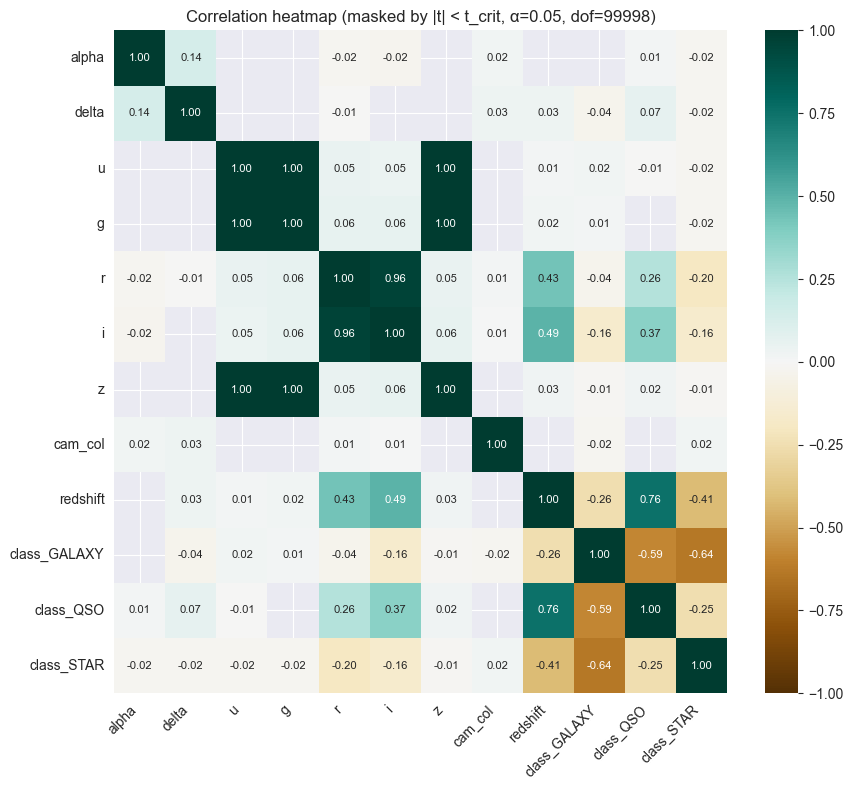

In [46]:
from scipy import stats
# corr: матрица корреляций (из твоего кода)
# NUM:  числовой DataFrame, по которому считали corr
n = len(NUM)                 # для Xdf без NaN по колонкам это корректно
dfree = n - 2

# t-статистика для Pearson (и допуск для Spearman как приближение)
T = corr * np.sqrt(dfree / np.maximum(1 - corr**2, 1e-12))
alpha = 0.05                 # уровень значимости (двусторонний)
tcrit = stats.t.ppf(1 - alpha/2, df=dfree)

# маска: True = скрыть клетку как "не значимо"
mask = T.abs() < tcrit
# диагональ оставим видимой (r=1, t=∞)
np.fill_diagonal(mask.values, False)

# перерисуем теплокарту корреляций c маской значимости
cols = corr.columns.tolist()
ncols = len(cols)
plt.figure(figsize=(max(8, 0.5*ncols + 3), max(6, 0.5*ncols + 2)))
ax = sns.heatmap(
    corr, mask=mask, vmin=-1, vmax=1, cmap="BrBG",
    annot=True, fmt=".2f", annot_kws={"size":8}, linewidths=0
)
ax.set_title(f"Correlation heatmap (masked by |t| < t_crit, α={alpha}, dof={dfree})")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout(); plt.show()

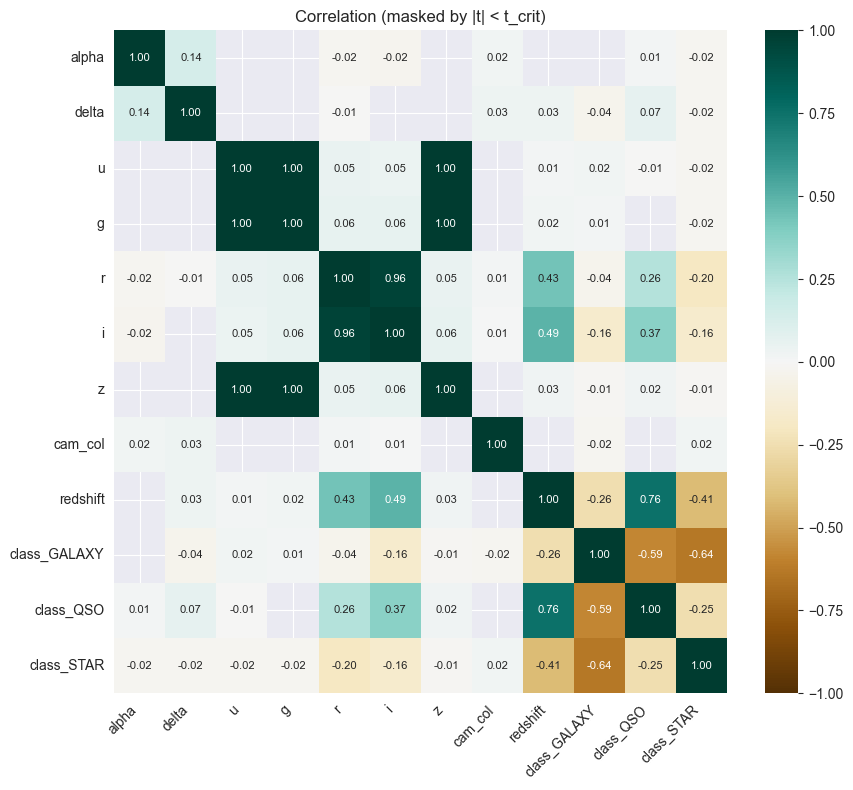

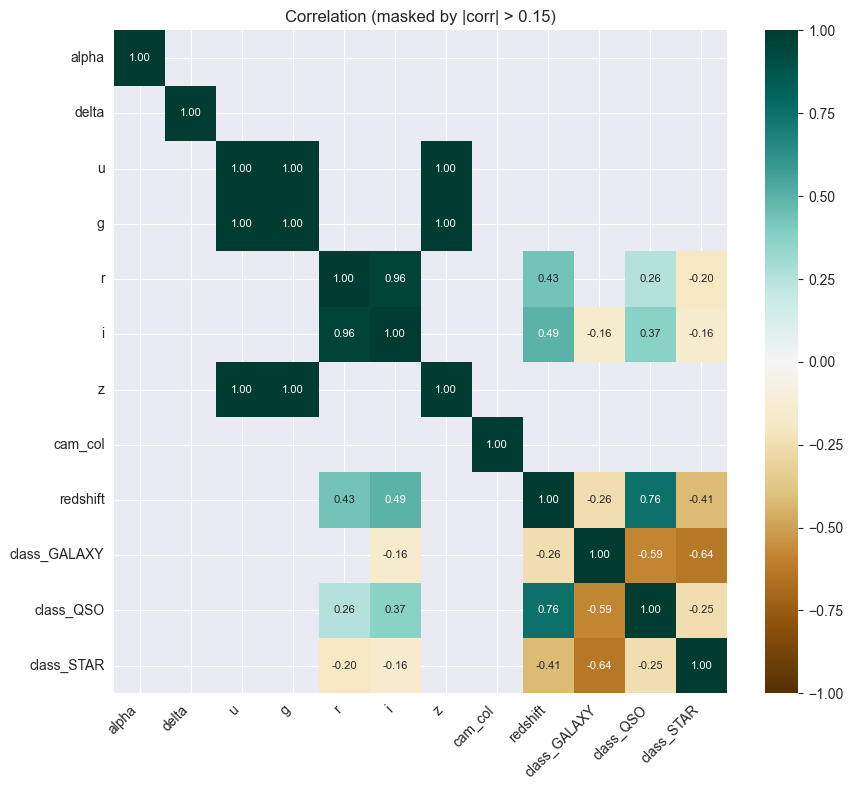

In [48]:
n = len(NUM)
dfree = n - 2

# 1) Маска по значимости (двусторонний тест)
T = corr * np.sqrt(dfree / np.maximum(1 - corr**2, 1e-12))
alpha = 0.05
tcrit = stats.t.ppf(1 - alpha/2, df=dfree)
mask_sig = T.abs() < tcrit
np.fill_diagonal(mask_sig.values, False)

plt.figure(figsize=(max(8, 0.5*len(corr)+3), max(6, 0.5*len(corr)+2)))
ax = sns.heatmap(corr, mask=mask_sig, vmin=-1, vmax=1, cmap="BrBG",
                 annot=True, fmt=".2f", annot_kws={"size":8}, linewidths=0)
ax.set_title(f"Correlation (masked by |t| < t_crit)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout(); plt.show()

# 2) Маска по величине эффекта: показываем только |corr| >= 0.15
thr = 0.15
mask_thr = corr.abs() < thr
np.fill_diagonal(mask_thr.values, False)

plt.figure(figsize=(max(8, 0.5*len(corr)+3), max(6, 0.5*len(corr)+2)))
ax = sns.heatmap(corr, mask=mask_thr, vmin=-1, vmax=1, cmap="BrBG",
                 annot=True, fmt=".2f", annot_kws={"size":8}, linewidths=0)
ax.set_title(f"Correlation (masked by |corr| > {thr})")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout(); plt.show()